In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

kbalaji08_wisdm_dataset_path = kagglehub.dataset_download('kbalaji08/wisdm-dataset')
kbalaji08_trackdatset_path = kagglehub.dataset_download('kbalaji08/trackdatset')

print('Data source import complete.')


100%|██████████| 11.0M/11.0M [00:00<00:00, 44.3MB/s]

Extracting files...


100%|██████████| 96.4M/96.4M [00:01<00:00, 81.3MB/s]

Extracting files...


Data source import complete.


In [ ]:
import pandas as pd

# Path to your raw text file
file_path = '/content/drive/MyDrive/Walk and Beat/data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'

# Read and preprocess the data
rows = []
with open(file_path, 'r') as f:
    for line in f:
        parts = line.strip().split(',')
        if len(parts) < 6:
            continue
        try:
            user = int(parts[0])
            activity = parts[1]
            timestamp = int(parts[2])
            x = float(parts[3])
            y = float(parts[4])
            z = float(parts[5].replace(';', ''))
            rows.append([user, activity, timestamp, x, y, z])
        except Exception as e:
            continue

df = pd.DataFrame(rows, columns=['user', 'activity', 'timestamp', 'x', 'y', 'z'])
df['timestamp'] = df['timestamp'] / 1e9  # Optional: Convert nanoseconds to seconds

# Preview the result
print(df.shape)
df.head()


(1098203, 6)


,user,activity,timestamp,x,y,z
0,33,Jogging,49105.962326,-0.694638,12.680544,0.503953
1,33,Jogging,49106.062271,5.012288,11.264028,0.953424
2,33,Jogging,49106.112167,4.903325,10.882658,-0.081722
3,33,Jogging,49106.222305,-0.612916,18.496431,3.023717
4,33,Jogging,49106.332290,-1.184970,12.108489,7.205164


In [ ]:
# Group by user and activity, then count the number of samples
user_activity_counts = df.groupby(['user', 'activity']).size().reset_index(name='count')

# Preview the counts
print(user_activity_counts.head(10))

# Pivot for user vs activity table
user_activity_pivot = user_activity_counts.pivot(index='user', columns='activity', values='count').fillna(0)
print(user_activity_pivot.head(10))


   user    activity  count
0     1  Downstairs   2941
1     1     Jogging  11056
2     1    Upstairs   3120
3     1     Walking  12861
4     2     Jogging  11786
5     2     Walking  11739
6     3  Downstairs   3326
7     3     Jogging  11018
8     3     Sitting   1609
9     3    Standing   2824
activity  Downstairs  Jogging  Sitting  Standing  Upstairs  Walking
user                                                               
1             2941.0  11056.0      0.0       0.0    3120.0  12861.0
2                0.0  11786.0      0.0       0.0       0.0  11739.0
3             3326.0  11018.0   1609.0    2824.0    3411.0  12973.0
4             1763.0    895.0   1257.0       0.0    1377.0   6079.0
5             3281.0   6405.0   1664.0    1515.0    3387.0  12257.0
6             1433.0  11818.0   1679.0     709.0    1666.0  12399.0
7             2257.0   9183.0   2529.0    2364.0    3601.0  11033.0
8             3346.0  10313.0   2699.0    3269.0    4453.0  17108.0
9                0.0   

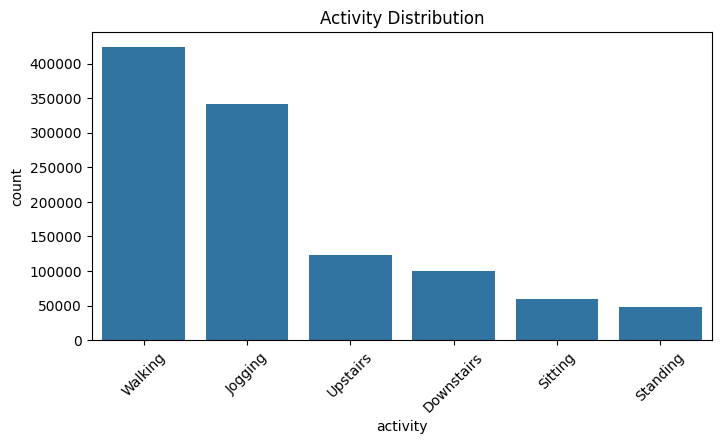

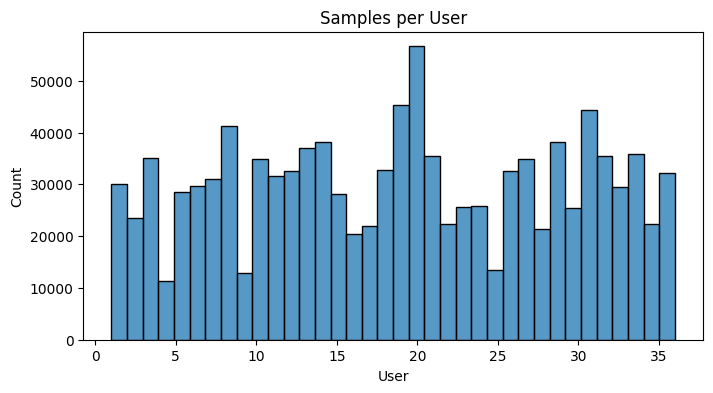

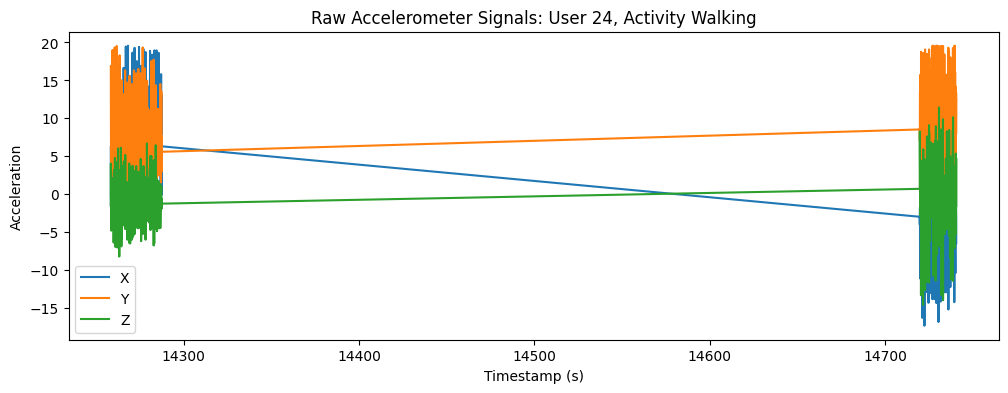

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class/activity distribution
plt.figure(figsize=(8,4))
sns.countplot(x='activity', data=df, order=df['activity'].value_counts().index)
plt.title('Activity Distribution')
plt.xticks(rotation=45)
plt.show()

# User data point distribution
plt.figure(figsize=(8,4))
sns.histplot(df['user'], bins=36)
plt.title('Samples per User')
plt.xlabel('User')
plt.show()

# Raw signal plot for a random user/activity
sample_user = df['user'].sample(1).iloc[0]
sample_act = df[df['user'] == sample_user]['activity'].unique()[0]
sample = df[(df['user'] == sample_user) & (df['activity'] == sample_act)].head(1000)
plt.figure(figsize=(12,4))
plt.plot(sample['timestamp'], sample['x'], label='X')
plt.plot(sample['timestamp'], sample['y'], label='Y')
plt.plot(sample['timestamp'], sample['z'], label='Z')
plt.title(f'Raw Accelerometer Signals: User {sample_user}, Activity {sample_act}')
plt.xlabel('Timestamp (s)')
plt.ylabel('Acceleration')
plt.legend()
plt.show()


In [ ]:
import numpy as np
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis

WINDOW_SIZE = 100  # 5 seconds at 20 Hz, adjust if needed

def extract_features(window):
    features = {}
    axes = ['x', 'y', 'z']
    for axis in axes:
        values = window[axis].values
        features[f'mean_{axis}'] = np.mean(values)
        features[f'std_{axis}'] = np.std(values)
        features[f'min_{axis}'] = np.min(values)
        features[f'max_{axis}'] = np.max(values)
        features[f'median_{axis}'] = np.median(values)
        features[f'skew_{axis}'] = skew(values)
        features[f'kurtosis_{axis}'] = kurtosis(values)
        features[f'energy_{axis}'] = np.sum(values**2)
    # Magnitude-based features
    mag = np.sqrt(window['x']**2 + window['y']**2 + window['z']**2)
    features['mean_mag'] = np.mean(mag)
    features['std_mag'] = np.std(mag)
    # Step rate via peak detection
    peaks, _ = find_peaks(mag, distance=5)
    duration = window['timestamp'].iloc[-1] - window['timestamp'].iloc[0]
    features['step_rate'] = 60 * len(peaks) / (duration if duration > 0 else 1)
    features['num_peaks'] = len(peaks)
    if len(peaks) > 1:
        interpeak = np.diff(window['timestamp'].iloc[peaks])
        features['mean_interpeak'] = np.mean(interpeak)
        features['std_interpeak'] = np.std(interpeak)
    else:
        features['mean_interpeak'] = 0
        features['std_interpeak'] = 0
    # Meta
    features['user'] = window['user'].iloc[0]
    features['activity'] = window['activity'].iloc[0]
    return features

# Apply windowing with no overlap
features_list = []
for user in df['user'].unique():
    for act in df[df['user'] == user]['activity'].unique():
        sub = df[(df['user'] == user) & (df['activity'] == act)]
        for start in range(0, len(sub) - WINDOW_SIZE + 1, WINDOW_SIZE):
            window = sub.iloc[start:start + WINDOW_SIZE]
            features = extract_features(window)
            features_list.append(features)

features_df = pd.DataFrame(features_list)
print("Feature shape:", features_df.shape)
features_df.head()


Feature shape: (10887, 32)


,mean_x,std_x,min_x,max_x,median_x,skew_x,kurtosis_x,energy_x,mean_y,std_y,...,kurtosis_z,energy_z,mean_mag,std_mag,step_rate,num_peaks,mean_interpeak,std_interpeak,user,activity
0,-0.057478,3.936272,-8.662541,11.604536,-0.612916,0.215901,0.072366,1549.753942,8.581909,7.781448,...,0.155631,2947.250315,11.914043,6.101287,80.076339,14,0.729999,0.139404,33,Jogging
1,-0.280988,4.156854,-9.425281,12.299174,-0.538004,0.140362,-0.192079,1735.838643,8.226826,8.533715,...,-0.457352,2816.307776,11.998831,6.484943,86.872201,15,0.714999,0.126654,33,Jogging
2,-1.594807,4.649891,-13.593107,7.886181,-0.932994,-0.655787,0.202208,2416.489772,7.985065,8.197227,...,0.328331,3517.368436,12.141786,6.547626,91.341493,16,0.662008,0.120550,33,Jogging
3,0.199402,5.889370,-12.530720,11.114203,0.442661,-0.183245,-0.788615,3472.444139,7.250792,8.160406,...,0.893714,2690.605982,11.967123,6.130634,79.772549,14,0.781534,0.191978,33,Jogging
4,-0.968543,5.232160,-14.246883,10.800936,-0.721878,-0.235713,-0.162626,2831.357754,8.005496,8.346463,...,0.780705,3692.791606,12.165538,7.140909,90.140896,16,0.691329,0.124486,33,Jogging


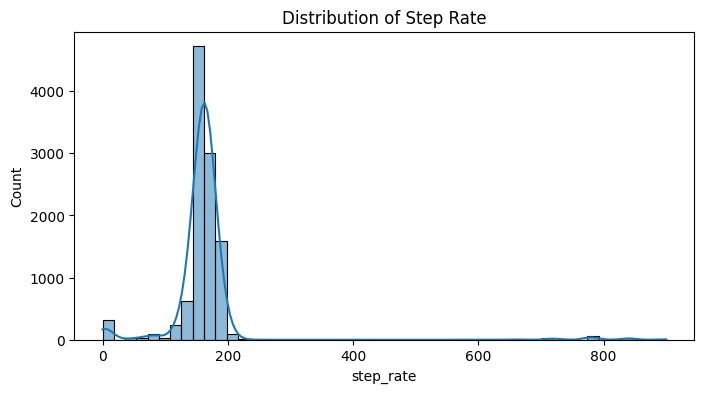

Shape after outlier removal: (10320, 32)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of step rate
plt.figure(figsize=(8,4))
sns.histplot(features_df['step_rate'], bins=50, kde=True)
plt.title('Distribution of Step Rate')
plt.show()

# Remove windows with unrealistic step rates (e.g., negative, >220, or <40 steps/min)
features_df = features_df[(features_df['step_rate'] > 40) & (features_df['step_rate'] < 220)]

# Remove windows with extreme mean_mag or std_mag (±3 standard deviations)
for col in ['mean_mag', 'std_mag']:
    mean, std = features_df[col].mean(), features_df[col].std()
    features_df = features_df[(features_df[col] > mean - 3*std) & (features_df[col] < mean + 3*std)]

print("Shape after outlier removal:", features_df.shape)


In [ ]:
filtered_df = features_df[features_df['activity'].isin(['Walking', 'Jogging'])].reset_index(drop=True)


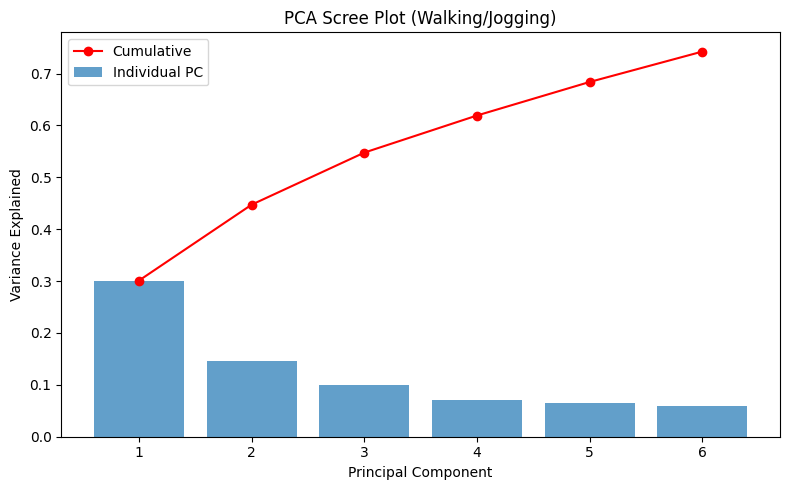

Top 3 features for each PC:
PC1: min_y, std_x, min_z
PC2: energy_y, mean_x, median_x
PC3: max_x, max_y, mean_x
PC4: max_z, mean_interpeak, skew_z
PC5: mean_z, median_z, std_interpeak
PC6: max_z, mean_interpeak, std_interpeak


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px

# 1. Select relevant features (step_rate NOT included as feature!)
numerical_features = [
    'mean_x', 'std_x', 'min_x', 'max_x', 'median_x', 'skew_x', 'kurtosis_x', 'energy_x',
    'mean_y', 'std_y', 'min_y', 'max_y', 'median_y', 'skew_y', 'kurtosis_y', 'energy_y',
    'mean_z', 'std_z', 'min_z', 'max_z', 'median_z', 'skew_z', 'kurtosis_z', 'energy_z',
    'mean_mag', 'std_mag',
    'num_peaks', 'mean_interpeak', 'std_interpeak'
]
# Filter out any missing features from your dataframe (in case)
numerical_features = [f for f in numerical_features if f in filtered_df.columns]
X = filtered_df[numerical_features]
y = filtered_df['step_rate']
labels = filtered_df['activity']

# 2. Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. PCA (choose n_components, e.g., 6 based on scree elbow)
n_pcs = 6
pca = PCA(n_components=n_pcs)
X_pca = pca.fit_transform(X_scaled)

# 4. Scree plot
explained_var = pca.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)
plt.figure(figsize=(8,5))
plt.bar(range(1, n_pcs+1), explained_var, alpha=0.7, label='Individual PC')
plt.plot(range(1, n_pcs+1), cum_explained_var, marker='o', color='red', label='Cumulative')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('PCA Scree Plot (Walking/Jogging)')
plt.xticks(range(1, n_pcs+1))
plt.legend()
plt.tight_layout()
plt.show()

# 5. Scatter plot of first 2 PCs
pca_columns = [f'PC{i+1}' for i in range(n_pcs)]
features_pca_df = pd.DataFrame(X_pca, columns=pca_columns)
features_pca_df['label'] = labels.values
features_pca_df['user'] = filtered_df['user'].values
features_pca_df['step_rate'] = y.values

fig = px.scatter(
    features_pca_df, x='PC1', y='PC2', color='label',
    title='PCA: First 2 Principal Components (Walking vs Jogging)'
)
fig.show()

# 6. Show top features per PC
loadings = pd.DataFrame(
    pca.components_.T,
    columns=pca_columns,
    index=numerical_features
)
print("Top 3 features for each PC:")
for i in range(n_pcs):
    top_feats = loadings.iloc[:, i].abs().sort_values(ascending=False).head(3)
    print(f"PC{i+1}: {', '.join(top_feats.index)}")

# 7. Save PCA features for downstream modeling
features_pca_df.to_csv('wisdm_pca_features_selected.csv', index=False)


In [ ]:
!pip install --quiet mlflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.8/681.8 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 19.7 MB/s eta 0:00:00


In [ ]:
import os, json, joblib, numpy as np, pandas as pd
from pathlib import Path
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score, classification_report, confusion_matrix
import mlflow, mlflow.sklearn
from mlflow.models.signature import infer_signature

# -----------------------------
# 0) Paths & helpers
# -----------------------------
ARTIFACTS = Path("/content/drive/MyDrive/Walk and Beat/artifacts"); ARTIFACTS.mkdir(parents=True, exist_ok=True)
EVALDIR   = ARTIFACTS/"eval"; EVALDIR.mkdir(parents=True, exist_ok=True)

def cadence_window_accuracy(y_true, y_pred, pct=0.10):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return float(np.mean(np.abs(y_pred - y_true) <= (pct * np.abs(y_true))))

def critical_error_rate(y_true, y_pred, pct=0.25):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return float(np.mean(np.abs(y_pred - y_true) > (pct * np.abs(y_true))))

# -----------------------------
# 1) Data split (your logic)
# -----------------------------
X = features_pca_df[[c for c in features_pca_df.columns if c.startswith('PC')]]
y_reg = features_pca_df['step_rate'].astype(float)
y_class = features_pca_df['label'].astype(str)

X_trainval, X_test, y_reg_trainval, y_reg_test, y_class_trainval, y_class_test = train_test_split(
    X, y_reg, y_class, test_size=0.30, random_state=42, stratify=y_class
)
X_train, X_val, y_reg_train, y_reg_val, y_class_train, y_class_val = train_test_split(
    X_trainval, y_reg_trainval, y_class_trainval, test_size=0.20, random_state=42, stratify=y_class_trainval
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# -----------------------------
# 2) Hyperparameter grid
# -----------------------------
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

# -----------------------------
# 3) MLflow experiment
# -----------------------------
mlflow.set_tracking_uri("file://" + str(Path.cwd() / "mlruns"))
mlflow.set_experiment("cadence_activity_modeling")

best_score = -np.inf
best_payload = None
cv_rows = []

PATIENCE = 5
no_improve = 0
trial_idx = 0

with mlflow.start_run(run_name="RF_grid_search_parent") as parent_run:
    for n_est in param_grid['n_estimators']:
        for m_depth in param_grid['max_depth']:
            trial_idx += 1
            with mlflow.start_run(run_name=f"trial_{trial_idx}", nested=True) as run:
                # ----- train models -----
                reg = RandomForestRegressor(n_estimators=n_est, max_depth=m_depth, random_state=42, n_jobs=-1)
                reg.fit(X_train, y_reg_train)
                y_val_reg = reg.predict(X_val)
                reg_mae   = mean_absolute_error(y_reg_val, y_val_reg)
                reg_cwa10 = cadence_window_accuracy(y_reg_val, y_val_reg, pct=0.10)
                reg_cer25 = critical_error_rate(y_reg_val, y_val_reg, pct=0.25)

                clf = RandomForestClassifier(n_estimators=n_est, max_depth=m_depth, random_state=42, n_jobs=-1)
                clf.fit(X_train, y_class_train)
                y_val_cls = clf.predict(X_val)
                clf_acc   = accuracy_score(y_class_val, y_val_cls)
                clf_f1    = f1_score(y_class_val, y_val_cls, average='weighted')

                # ----- log params/metrics -----
                mlflow.log_param("n_estimators", n_est)
                mlflow.log_param("max_depth", m_depth)
                mlflow.log_metrics({
                    "reg_val_mae": reg_mae,
                    "reg_val_cwa10": reg_cwa10,
                    "reg_val_cer25": reg_cer25,
                    "clf_val_acc": clf_acc,
                    "clf_val_f1": clf_f1
                })

                # ----- log models with signature -----
                try:
                    sig_reg = infer_signature(X_val, y_val_reg)
                    mlflow.sklearn.log_model(reg, artifact_path="regressor", input_example=X_val.iloc[:5], signature=sig_reg)
                except Exception:
                    mlflow.sklearn.log_model(reg, artifact_path="regressor")

                try:
                    sig_clf = infer_signature(X_val, y_val_cls)
                    mlflow.sklearn.log_model(clf, artifact_path="classifier", input_example=X_val.iloc[:5], signature=sig_clf)
                except Exception:
                    mlflow.sklearn.log_model(clf, artifact_path="classifier")

                # ----- selection score & patience -----
                # Emphasize accuracy, F1, CWA; penalize MAE slightly
                score = (clf_acc * 2.0 + clf_f1 + reg_cwa10) - 0.05 * reg_mae

                cv_rows.append({
                    "trial": trial_idx,
                    "n_estimators": n_est,
                    "max_depth": m_depth,
                    "reg_val_mae": reg_mae,
                    "reg_val_cwa10": reg_cwa10,
                    "reg_val_cer25": reg_cer25,
                    "clf_val_acc": clf_acc,
                    "clf_val_f1": clf_f1,
                    "score": score
                })

                if score > best_score + 1e-6:  # significant tiny bump
                    best_score = score
                    best_payload = {
                        "run_id": run.info.run_id,
                        "reg": reg,
                        "clf": clf,
                        "params": {"n_estimators": n_est, "max_depth": m_depth},
                        "val": {"reg_mae": reg_mae, "clf_acc": clf_acc}
                    }
                    no_improve = 0
                else:
                    no_improve += 1

            if no_improve >= PATIENCE:
                print(f"[Early stop] No improvement for {PATIENCE} trials.")
                break

# -----------------------------
# 4) Save best artifacts & test eval
# -----------------------------
assert best_payload is not None, "No successful trials?"

# Save best models to artifacts/
joblib.dump(best_payload["reg"], ARTIFACTS/"best_regressor.pkl")
joblib.dump(best_payload["clf"], ARTIFACTS/"best_classifier.pkl")
# Save optional preprocessors if they exist in this notebook session
if 'pca' in globals(): joblib.dump(pca, ARTIFACTS/"pca.pkl")
if 'scaler' in globals(): joblib.dump(scaler, ARTIFACTS/"scaler.pkl")
# Save label classes (for downstream)
np.save(ARTIFACTS/"label_classes.npy", np.array(sorted(y_class.unique()), dtype='<U32'))
# Save run id for auditability
(Path(ARTIFACTS/"best_run.txt")).write_text(best_payload["run_id"])

# Persist the full PC table we trained on (for eval notebook)
features_pca_df.to_parquet(ARTIFACTS/"features_pca.parquet", index=False)

# ---- Final test metrics
best_reg = best_payload["reg"]; best_clf = best_payload["clf"]
y_test_reg = best_reg.predict(X_test)
y_test_cls = best_clf.predict(X_test)

test_metrics = {
    "reg_test_mae": float(mean_absolute_error(y_reg_test, y_test_reg)),
    "reg_test_cwa10": cadence_window_accuracy(y_reg_test, y_test_reg, pct=0.10),
    "reg_test_cer25": critical_error_rate(y_reg_test, y_test_reg, pct=0.25),
    "clf_test_acc": float(accuracy_score(y_class_test, y_test_cls)),
    "clf_test_f1": float(f1_score(y_class_test, y_test_cls, average='weighted')),
    "timestamp": datetime.utcnow().isoformat(),
    "best_run_id": best_payload["run_id"],
    "pc_count": int(X.shape[1])
}

print("\n--- Step Rate Regression: Test Set ---")
print(f"Test MAE: {test_metrics['reg_test_mae']:.2f}")
print(f"Test Cadence Window Accuracy (±10%): {test_metrics['reg_test_cwa10']:.2%}")
print(f"Test Critical Error Rate (>25%): {test_metrics['reg_test_cer25']:.2%}")

print("\n--- Activity Classification: Test Set ---")
print(f"Test Accuracy: {test_metrics['clf_test_acc']:.3f}")
print(f"Test F1 (weighted): {test_metrics['clf_test_f1']:.3f}")

# -----------------------------
# 5) Write CSVs for the eval pipeline
# -----------------------------
pd.DataFrame([test_metrics]).to_csv(EVALDIR/"metrics_test.csv", index=False)
pd.DataFrame(cv_rows).sort_values("score", ascending=False).to_csv(EVALDIR/"cv_metrics.csv", index=False)
print("Saved:", (EVALDIR/"metrics_test.csv").resolve(), "and", (EVALDIR/"cv_metrics.csv").resolve())

# -----------------------------
# 6) Persist test split for standalone evaluation
# -----------------------------
from pathlib import Path
import json
import numpy as np

SPLITDIR = ARTIFACTS / "splits"
SPLITDIR.mkdir(parents=True, exist_ok=True)

# Keep only PC columns for X
pc_cols = [c for c in features_pca_df.columns if c.startswith("PC")]
X_test_df = X_test.copy()
X_test_df["row_id"] = X_test.index  # preserve index for traceability
X_test_df = X_test_df.reset_index(drop=True)

# Regression & classification targets with row_id
y_reg_test_df = pd.DataFrame({"row_id": X_test.index, "step_rate": y_reg_test.values})
y_class_test_df = pd.DataFrame({"row_id": X_test.index, "label": y_class_test.values})

# Also store the full original rows for the test split (handy for audits/user-wise eval)
cols_keep = ["user", "label", "step_rate"] + pc_cols
inter = features_pca_df.loc[X_test.index, cols_keep].copy()
inter["row_id"] = X_test.index
inter = inter.reset_index(drop=True)

# --- Save as Parquet AND CSV (to be Colab-friendly) ---
X_test_df.to_parquet(SPLITDIR / "X_test.parquet", index=False)
X_test_df.to_csv(SPLITDIR / "X_test.csv", index=False)

y_reg_test_df.to_csv(SPLITDIR / "y_reg_test.csv", index=False)
y_class_test_df.to_csv(SPLITDIR / "y_class_test.csv", index=False)

inter.to_parquet(SPLITDIR / "test_rows.parquet", index=False)

# Save the raw test indices
np.save(SPLITDIR / "test_index.npy", X_test.index.values)

# Small manifest to make the eval notebook dead simple
manifest = {
    "pc_columns": pc_cols,
    "paths": {
        "X_test_parquet": str((SPLITDIR / "X_test.parquet").resolve()),
        "X_test_csv": str((SPLITDIR / "X_test.csv").resolve()),
        "y_reg_test_csv": str((SPLITDIR / "y_reg_test.csv").resolve()),
        "y_class_test_csv": str((SPLITDIR / "y_class_test.csv").resolve()),
        "test_rows_parquet": str((SPLITDIR / "test_rows.parquet").resolve()),
        "test_index_npy": str((SPLITDIR / "test_index.npy").resolve()),
        "best_regressor_pkl": str((ARTIFACTS / "best_regressor.pkl").resolve()),
        "best_classifier_pkl": str((ARTIFACTS / "best_classifier.pkl").resolve()),
        "scaler_pkl": str((ARTIFACTS / "scaler.pkl").resolve()) if (ARTIFACTS / "scaler.pkl").exists() else None,
        "pca_pkl": str((ARTIFACTS / "pca.pkl").resolve()) if (ARTIFACTS / "pca.pkl").exists() else None,
        "features_pca_parquet": str((ARTIFACTS / "features_pca.parquet").resolve()),
        "metrics_test_csv": str((EVALDIR / "metrics_test.csv").resolve()),
        "cv_metrics_csv": str((EVALDIR / "cv_metrics.csv").resolve()),
        "best_run_txt": str((ARTIFACTS / "best_run.txt").resolve()),
    },
    "shapes": {
        "X_test": list(X_test.shape),
        "y_reg_test": int(len(y_reg_test)),
        "y_class_test": int(len(y_class_test)),
    }
}
with open(SPLITDIR / "manifest.json", "w") as f:
    json.dump(manifest, f, indent=2)

print("\n[Saved evaluation splits & manifest]")
print(json.dumps(manifest["paths"], indent=2))



Train: (4043, 6), Val: (1011, 6), Test: (2167, 6)


2025/08/08 05:00:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/08 05:00:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/08 05:00:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/08 05:00:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/08 05:00:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/08 05:00:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/08 05:00:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/08 05:00:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/08 05:01:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/08 05:01:07 WARNING mlflow.mo


--- Step Rate Regression: Test Set ---
Test MAE: 4.26
Test Cadence Window Accuracy (±10%): 98.66%
Test Critical Error Rate (>25%): 0.18%

--- Activity Classification: Test Set ---
Test Accuracy: 0.993
Test F1 (weighted): 0.993
Saved: /content/drive/MyDrive/Walk and Beat/artifacts/eval/metrics_test.csv and /content/drive/MyDrive/Walk and Beat/artifacts/eval/cv_metrics.csv

[Saved evaluation splits & manifest]
{
  "X_test_parquet": "/content/drive/MyDrive/Walk and Beat/artifacts/splits/X_test.parquet",
  "X_test_csv": "/content/drive/MyDrive/Walk and Beat/artifacts/splits/X_test.csv",
  "y_reg_test_csv": "/content/drive/MyDrive/Walk and Beat/artifacts/splits/y_reg_test.csv",
  "y_class_test_csv": "/content/drive/MyDrive/Walk and Beat/artifacts/splits/y_class_test.csv",
  "test_rows_parquet": "/content/drive/MyDrive/Walk and Beat/artifacts/splits/test_rows.parquet",
  "test_index_npy": "/content/drive/MyDrive/Walk and Beat/artifacts/splits/test_index.npy",
  "best_regressor_pkl": "/conte

In [ ]:
import pandas as pd

# File paths
features_path = '/content/drive/MyDrive/Walk and Beat/data/Spotify Dataset/spotify_features_data_2023.csv'
tracks_path = '/content/drive/MyDrive/Walk and Beat/data/Spotify Dataset/spotify_tracks_data_2023.csv'
artist_path = '/content/drive/MyDrive/Walk and Beat/data/Spotify Dataset/spotify_artist_data_2023.csv'
albums_path = '/content/drive/MyDrive/Walk and Beat/data/Spotify Dataset/spotify-albums_data_2023.csv'
data_path = '/content/drive/MyDrive/Walk and Beat/data/Spotify Dataset/spotify_data_12_20_2023.csv'

# Load CSVs
features_df_songs = pd.read_csv(features_path)
tracks_df = pd.read_csv(tracks_path)
artist_df = pd.read_csv(artist_path)
albums_df = pd.read_csv(albums_path)
data_df = pd.read_csv(data_path)

# Preview columns to find which files contain track name, artist, and bpm/tempo
print("Features columns:", features_df_songs.columns.tolist())
print("Tracks columns:", tracks_df.columns.tolist())
print("Artist columns:", artist_df.columns.tolist())
print("Albums columns:", albums_df.columns.tolist())
print("Data columns:", data_df.columns.tolist())


/tmp/ipython-input-1507451109.py:15: DtypeWarning:

Columns (25,26,44) have mixed types. Specify dtype option on import or set low_memory=False.



Features columns: ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature']
Tracks columns: ['id', 'track_popularity', 'explicit']
Artist columns: ['id', 'name', 'artist_popularity', 'artist_genres', 'followers', 'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6']
Albums columns: ['track_name', 'track_id', 'track_number', 'duration_ms', 'album_type', 'artists', 'total_tracks', 'album_name', 'release_date', 'label', 'album_popularity', 'album_id', 'artist_id', 'artist_0', 'artist_1', 'artist_2', 'artist_3', 'artist_4', 'artist_5', 'artist_6', 'artist_7', 'artist_8', 'artist_9', 'artist_10', 'artist_11', 'duration_sec']
Data columns: ['album_id', 'album_name', 'album_popularity', 'album_type', 'artists', 'artist_0', 'artist_1', 'artist_2', 'artist_3', 'artist_4', 'artist_id', 'duration_sec', 'label', 'r

In [ ]:
# --- Iteration 1: Direct window → song matching using saved best models ---

import os, joblib, numpy as np, pandas as pd
from pathlib import Path

ARTIFACTS = Path("/content/drive/MyDrive/Walk and Beat/artifacts")
EVALDIR = ARTIFACTS / "eval"
EVALDIR.mkdir(parents=True, exist_ok=True)

# 0) Load best models (trained on PCA features)
reg = joblib.load(ARTIFACTS / "best_regressor.pkl")
# classifier is optional for Iteration 1; if present, we can filter to W/J
clf_path = ARTIFACTS / "best_classifier.pkl"
clf = joblib.load(clf_path) if clf_path.exists() else None

# 1) Prepare song dataframe with correct columns and BPM as float
features_df_songs = features_df_songs.copy()
if 'tempo' in features_df_songs.columns:
    features_df_songs = features_df_songs.rename(columns={'tempo': 'bpm'})

song_df = pd.merge(
    features_df_songs,
    albums_df[['track_id', 'track_name', 'artist_id', 'duration_ms']] if 'duration_ms' in albums_df.columns else albums_df[['track_id', 'track_name', 'artist_id']],
    left_on='id', right_on='track_id', how='inner'
)
song_df = pd.merge(
    song_df,
    artist_df[['id', 'name']].rename(columns={'id': 'artist_id', 'name': 'artist_name'}),
    on='artist_id',
    how='left'
)

keep_cols = ['track_name', 'artist_name', 'bpm']
if 'duration_ms' in song_df.columns:
    keep_cols.append('duration_ms')

song_df = song_df[keep_cols]
song_df = song_df.dropna(subset=['track_name', 'artist_name', 'bpm']).reset_index(drop=True)
song_df['bpm'] = pd.to_numeric(song_df['bpm'], errors='coerce')
song_df = song_df.dropna(subset=['bpm'])

# 2) Simple BPM matcher
def recommend_dynamic_song(pred_bpm, song_df, tolerance=10):
    candidates = song_df[(song_df['bpm'] >= pred_bpm - tolerance) & (song_df['bpm'] <= pred_bpm + tolerance)]
    if not candidates.empty:
        closest_idx = (candidates['bpm'] - pred_bpm).abs().idxmin()
        return candidates.loc[closest_idx]
    else:
        closest_idx = (song_df['bpm'] - pred_bpm).abs().idxmin()
        return song_df.loc[closest_idx]

# 3) Run over all users (per 5s window) using the saved regressor (and classifier if present)
pc_cols = [c for c in features_pca_df.columns if c.startswith('PC')]
assert len(pc_cols) > 0, "No PCA columns found. Ensure you created features_pca_df with PCs."

test_results = []
for user in features_pca_df['user'].unique():
    df_user = features_pca_df[features_pca_df['user'] == user].copy()
    X_user = df_user[pc_cols]

    # Predict cadence
    pred_step_rates = reg.predict(X_user)

    # (Optional) Predict activity to filter to Walking/Jogging windows only
    if clf is not None:
        pred_activity = clf.predict(X_user)
        df_user['pred_activity'] = pred_activity
        mask_wj = np.isin(pred_activity, ['Walking', 'Jogging'])
        # If you want to *only* recommend for W/J windows, uncomment:
        # df_user = df_user[mask_wj]
        # pred_step_rates = pred_step_rates[mask_wj]

    # Recommend songs window-by-window
    recommended_tracks, recommended_artists, recommended_bpms = [], [], []
    for pred_bpm in pred_step_rates:
        song = recommend_dynamic_song(pred_bpm, song_df, tolerance=10)
        recommended_tracks.append(song['track_name'])
        recommended_artists.append(song['artist_name'])
        recommended_bpms.append(song['bpm'])

    df_user['pred_step_rate'] = pred_step_rates
    df_user['rec_song'] = recommended_tracks
    df_user['rec_artist'] = recommended_artists
    df_user['rec_bpm'] = recommended_bpms

    test_results.append(df_user)

all_user_results = pd.concat(test_results, ignore_index=True)

# 4) Bespoke metrics (per user)
def cadence_music_fit_score(step_rates, song_bpms, tolerance=10):
    step_rates = np.asarray(step_rates, dtype=float)
    song_bpms = np.asarray(song_bpms, dtype=float)
    return float(np.mean(np.abs(step_rates - song_bpms) <= tolerance))

def song_segment_stats(song_sequence, window_len=5):
    s = pd.Series(song_sequence)
    change = s.ne(s.shift())  # True at first occurrence of a new song
    change_indices = np.where(change)[0]
    if len(change_indices) < 2:
        return {'num_changes': 0, 'mean_duration': len(s) * window_len}
    seg_lengths = np.diff(np.append(change_indices, len(s)))
    mean_seg = float(np.mean(seg_lengths) * window_len)
    return {
        'num_changes': int(len(change_indices) - 1),
        'mean_duration': mean_seg
    }

user_metrics = []
for user in all_user_results['user'].unique():
    df_user = all_user_results[all_user_results['user'] == user]
    fit_score = cadence_music_fit_score(df_user['pred_step_rate'], df_user['rec_bpm'], tolerance=10)
    seg_stats = song_segment_stats(df_user['rec_song'])
    user_metrics.append({
        'user': user,
        'cadence_music_fit': fit_score,
        'num_song_changes': seg_stats['num_changes'],
        'mean_song_segment_sec': seg_stats['mean_duration']
    })
metrics_df = pd.DataFrame(user_metrics)
print(metrics_df)

# 5) System-wide averages (for report)
print("\n--- System-wide averages (Iteration 1) ---")
print(f"Average cadence-music fit: {metrics_df['cadence_music_fit'].mean():.3f}")
print(f"Average number of song changes per session: {metrics_df['num_song_changes'].mean():.1f}")
print(f"Average song segment duration (sec): {metrics_df['mean_song_segment_sec'].mean():.2f}")

# 6) Save iteration-1 outputs for the eval pipeline
all_user_results.to_parquet(EVALDIR / "iter1_recommendations.parquet", index=False)
metrics_df.to_csv(EVALDIR / "iter1_user_metrics.csv", index=False)
print("\nSaved:")
print((EVALDIR / "iter1_recommendations.parquet").resolve())
print((EVALDIR / "iter1_user_metrics.csv").resolve())


    user  cadence_music_fit  num_song_changes  mean_song_segment_sec
0     33                1.0               171               5.000000
1     17                1.0               122               5.000000
2     20                1.0               214               5.000000
3     29                1.0               226               5.000000
4     13                1.0               233               5.000000
5     15                1.0               196               5.000000
6      6                1.0               220               5.000000
7     27                1.0               217               5.000000
8     36                1.0               174               5.000000
9     18                1.0               218               5.000000
10    32                1.0               201               5.000000
11    35                1.0               193               5.000000
12    11                1.0               242               5.000000
13    16                1.0       

In [ ]:
# --- Iteration 2: HMM smoothing + duration-aware song changes (using saved best models) ---

import os, joblib, numpy as np, pandas as pd
from pathlib import Path


ARTIFACTS = Path("/content/drive/MyDrive/Walk and Beat/artifacts")
EVALDIR = ARTIFACTS / "eval"
EVALDIR.mkdir(parents=True, exist_ok=True)

# 0) Load models and (if needed) features_pca_df
reg = joblib.load(ARTIFACTS / "best_regressor.pkl")
clf_path = ARTIFACTS / "best_classifier.pkl"
clf = joblib.load(clf_path) if clf_path.exists() else None

# If features_pca_df not already in memory, try to load the saved one
if "features_pca_df" not in globals():
    fp = ARTIFACTS / "features_pca.parquet"
    assert fp.exists(), "features_pca_df not found in memory and artifacts/features_pca.parquet not found."
    features_pca_df = pd.read_parquet(fp)

# 1) Prepare song dataframe (BPM, names, duration if available)
features_df_songs = features_df_songs.copy()
if "tempo" in features_df_songs.columns:
    features_df_songs = features_df_songs.rename(columns={"tempo": "bpm"})

merge_cols = ["track_id", "track_name", "artist_id"]
if "duration_ms" in albums_df.columns:
    merge_cols.append("duration_ms")

song_df = pd.merge(
    features_df_songs,
    albums_df[merge_cols],
    left_on="id", right_on="track_id", how="inner"
)
song_df = pd.merge(
    song_df,
    artist_df[["id", "name"]].rename(columns={"id": "artist_id", "name": "artist_name"}),
    on="artist_id", how="left"
)

keep_cols = ["track_name", "artist_name", "bpm"]
if "duration_ms" in song_df.columns:
    keep_cols.append("duration_ms")

song_df = song_df[keep_cols]
song_df = song_df.dropna(subset=["track_name", "artist_name", "bpm"]).reset_index(drop=True)
song_df["bpm"] = pd.to_numeric(song_df["bpm"], errors="coerce")
song_df = song_df.dropna(subset=["bpm"])

# 2) Predict cadence (steps/min) per window and discretize to cadence states
pc_cols = [c for c in features_pca_df.columns if c.startswith("PC")]
assert len(pc_cols) > 0, "No PCA columns found. Ensure features_pca_df contains PC columns."

def cadence_state(step_rate):
    if step_rate < 110:
        return "slow_walk"
    elif step_rate < 140:
        return "fast_walk"
    else:
        return "jog"

features_pca_df = features_pca_df.copy()
features_pca_df["pred_step_rate"] = reg.predict(features_pca_df[pc_cols])
features_pca_df["cadence_state"] = features_pca_df["pred_step_rate"].apply(cadence_state)

if clf is not None:
    features_pca_df["pred_activity"] = clf.predict(features_pca_df[pc_cols])

# 3) Learn HMM transition matrix from per-user cadence_state sequences
states = sorted(features_pca_df["cadence_state"].unique())
state2idx = {s: i for i, s in enumerate(states)}
n_states = len(states)

# Count transitions user-wise to avoid mixing unrelated sessions
trans_matrix = np.zeros((n_states, n_states), dtype=float)
for u in features_pca_df["user"].unique():
    seq = features_pca_df.loc[features_pca_df["user"] == u, "cadence_state"].values
    for i in range(len(seq) - 1):
        trans_matrix[state2idx[seq[i]], state2idx[seq[i + 1]]] += 1.0

# Row-normalize with smoothing to avoid zeros
row_sums = trans_matrix.sum(axis=1, keepdims=True)
trans_matrix = np.where(row_sums == 0, 1, trans_matrix)  # if a row is all zeros, make it uniform pre-norm
trans_matrix = trans_matrix / trans_matrix.sum(axis=1, keepdims=True)

# Save the learned transition matrix (for audit)
tm_df = pd.DataFrame(trans_matrix, index=states, columns=states)
tm_df.to_csv(EVALDIR / "iter2_hmm_transition_matrix.csv")

# 4) Viterbi smoothing with a simple emission: reward matching the raw predicted state, penalize mismatch
def viterbi_smooth(pred_states, trans_matrix, state2idx, states, mismatch_penalty=2.0, eps=1e-8):
    n = len(pred_states)
    S = trans_matrix.shape[0]
    dp = np.full((n, S), -np.inf, dtype=float)
    ptr = np.zeros((n, S), dtype=int)

    # Init – force start at the first predicted state (or allow soft prior if you prefer)
    for s in range(S):
        dp[0, s] = 0.0 if states[s] == pred_states[0] else -np.inf

    # DP
    logT = np.log(trans_matrix + eps)
    for t in range(1, n):
        for s in range(S):
            # emission: 0 if matches predicted state, -mismatch_penalty otherwise
            emit = 0.0 if states[s] == pred_states[t] else -mismatch_penalty
            # best previous
            v = dp[t - 1] + logT[:, s] + emit
            ptr[t, s] = np.argmax(v)
            dp[t, s] = v[ptr[t, s]]

    # Backtrack
    path_states = []
    s = int(np.argmax(dp[-1]))
    for t in range(n - 1, -1, -1):
        path_states.append(states[s])
        s = int(ptr[t, s])
    return path_states[::-1]

# 5) Recommender helpers
def recommend_dynamic_song(pred_bpm, song_df, tolerance=10):
    # Pick a track whose BPM is closest to cadence within ±tolerance, else closest overall.
    candidates = song_df[(song_df["bpm"] >= pred_bpm - tolerance) & (song_df["bpm"] <= pred_bpm + tolerance)]
    if not candidates.empty:
        closest_idx = (candidates["bpm"] - pred_bpm).abs().idxmin()
        return candidates.loc[closest_idx]
    closest_idx = (song_df["bpm"] - pred_bpm).abs().idxmin()
    return song_df.loc[closest_idx]

def get_track_duration(track_name, song_df):
    # Return duration in seconds; use median if multiple matches; default to 180s
    if "duration_ms" in song_df.columns:
        durs = song_df[song_df["track_name"] == track_name]["duration_ms"]
        if not durs.empty:
            return float(durs.median()) / 1000.0
    return 180.0

# 6) Run HMM smoothing + duration-aware recommendation per user
results_hmm = []

for user in features_pca_df["user"].unique():
    df_user = features_pca_df.loc[features_pca_df["user"] == user].copy()
    pred_states = df_user["cadence_state"].tolist()
    smooth_states = viterbi_smooth(pred_states, trans_matrix, state2idx, states)

    df_user["hmm_state"] = smooth_states

    rec_tracks, rec_artists, rec_bpms = [], [], []
    current_song = current_artist = None
    current_bpm = None
    song_timer = 0  # number of 5s windows left for current song
    last_state = None

    for _, row in df_user.iterrows():
        state = row["hmm_state"]
        pred_bpm = row["pred_step_rate"]

        # Change track if the robust (smoothed) state changed OR current song ended
        if (state != last_state) or (song_timer <= 0):
            s = recommend_dynamic_song(pred_bpm, song_df, tolerance=10)
            current_song = s["track_name"]
            current_artist = s["artist_name"]
            current_bpm = float(s["bpm"])

            dur_sec = get_track_duration(current_song, song_df)
            song_timer = int(max(1, dur_sec // 5))  # count in 5s windows
            last_state = state

        rec_tracks.append(current_song)
        rec_artists.append(current_artist)
        rec_bpms.append(current_bpm)
        song_timer -= 1

    df_user["hmm_rec_song"] = rec_tracks
    df_user["hmm_rec_artist"] = rec_artists
    df_user["hmm_rec_bpm"] = rec_bpms

    results_hmm.append(df_user)

all_user_hmm = pd.concat(results_hmm, ignore_index=True)

# 7) Bespoke metrics (per-user and aggregated)
def cadence_music_fit_score(step_rates, song_bpms, tolerance=10):
    step_rates = np.asarray(step_rates, dtype=float)
    song_bpms = np.asarray(song_bpms, dtype=float)
    return float(np.mean(np.abs(step_rates - song_bpms) <= tolerance))

def song_segment_stats(song_sequence, window_len=5):
    s = pd.Series(song_sequence)
    change = s.ne(s.shift())  # first occurrence of a new song
    change_idx = np.where(change)[0]
    if len(change_idx) < 2:
        return {"num_changes": 0, "mean_duration": float(len(s) * window_len)}
    seg_lengths = np.diff(np.append(change_idx, len(s)))
    return {
        "num_changes": int(len(change_idx) - 1),
        "mean_duration": float(np.mean(seg_lengths) * window_len),
    }

user_metrics_hmm = []
for user in all_user_hmm["user"].unique():
    df_user = all_user_hmm.loc[all_user_hmm["user"] == user]
    fit = cadence_music_fit_score(df_user["pred_step_rate"], df_user["hmm_rec_bpm"], tolerance=10)
    seg = song_segment_stats(df_user["hmm_rec_song"])
    user_metrics_hmm.append({
        "user": user,
        "cadence_music_fit": fit,
        "num_song_changes": seg["num_changes"],
        "mean_song_segment_sec": seg["mean_duration"]
    })
metrics_hmm_df = pd.DataFrame(user_metrics_hmm)
print(metrics_hmm_df)

print("\n--- System-wide averages (HMM Iteration) ---")
print(f"Average cadence-music fit: {metrics_hmm_df['cadence_music_fit'].mean():.3f}")
print(f"Average number of song changes per session: {metrics_hmm_df['num_song_changes'].mean():.1f}")
print(f"Average song segment duration (sec): {metrics_hmm_df['mean_song_segment_sec'].mean():.2f}")

# 8) Save iteration-2 outputs for the eval pipeline / professor
all_user_hmm.to_parquet(EVALDIR / "iter2_hmm_recommendations.parquet", index=False)
metrics_hmm_df.to_csv(EVALDIR / "iter2_hmm_user_metrics.csv", index=False)
print("\nSaved:")
print((EVALDIR / "iter2_hmm_recommendations.parquet").resolve())
print((EVALDIR / "iter2_hmm_user_metrics.csv").resolve())
print((EVALDIR / "iter2_hmm_transition_matrix.csv").resolve())


    user  cadence_music_fit  num_song_changes  mean_song_segment_sec
0     33           0.447674                 6             122.857143
1     17           0.626016                 7              76.875000
2     20           0.437209                 7             134.375000
3     29           0.621145                 7             141.875000
4     13           0.632479                 6             167.142857
5     15           0.543147                 5             164.166667
6      6           0.411765                 7             138.125000
7     27           0.339450                 6             155.714286
8     36           0.577143                 4             175.000000
9     18           0.456621                 6             156.428571
10    32           0.440594                 5             168.333333
11    35           0.582474                 5             161.666667
12    11           0.423868                 9             121.500000
13    16           0.472000       

In [ ]:
    !zip -r ml_runs_folder.zip mlruns

  adding: mlruns/ (stored 0%)
  adding: mlruns/0/ (stored 0%)
  adding: mlruns/0/meta.yaml (deflated 24%)
  adding: mlruns/126943327717679520/ (stored 0%)
  adding: mlruns/126943327717679520/0fb6791926d14635beb58e0fd3a2d621/ (stored 0%)
  adding: mlruns/126943327717679520/0fb6791926d14635beb58e0fd3a2d621/tags/ (stored 0%)
  adding: mlruns/126943327717679520/0fb6791926d14635beb58e0fd3a2d621/tags/mlflow.source.name (deflated 5%)
  adding: mlruns/126943327717679520/0fb6791926d14635beb58e0fd3a2d621/tags/mlflow.runName (stored 0%)
  adding: mlruns/126943327717679520/0fb6791926d14635beb58e0fd3a2d621/tags/mlflow.user (stored 0%)
  adding: mlruns/126943327717679520/0fb6791926d14635beb58e0fd3a2d621/tags/mlflow.source.type (stored 0%)
  adding: mlruns/126943327717679520/0fb6791926d14635beb58e0fd3a2d621/tags/mlflow.parentRunId (stored 0%)
  adding: mlruns/126943327717679520/0fb6791926d14635beb58e0fd3a2d621/metrics/ (stored 0%)
  adding: mlruns/126943327717679520/0fb6791926d14635beb58e0fd3a2d621/m